In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/sonar data.csv", header=None)
df.columns = [f"Feature_{i}" for i in range(60)] + ["Target"]

In [3]:
df.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [4]:

# split the data
x = df.iloc[:,:-1]
y = df['Target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42, stratify=y)

# data scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

              precision    recall  f1-score   support

           M       0.78      0.95      0.86        22
           R       0.93      0.70      0.80        20

    accuracy                           0.83        42
   macro avg       0.86      0.83      0.83        42
weighted avg       0.85      0.83      0.83        42



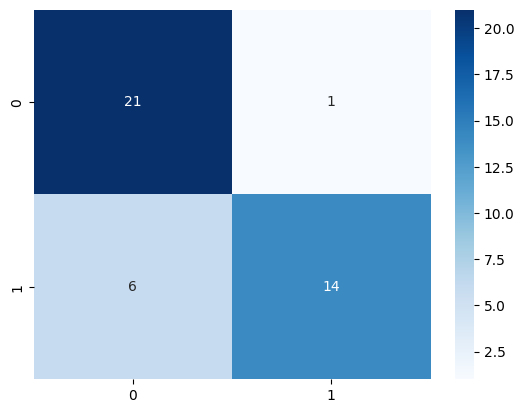

In [5]:
#base line model
Log_reg_model = LogisticRegression(max_iter=1000)
Log_reg_model.fit(x_train_scaled,y_train)

y_pred = Log_reg_model.predict(x_test_scaled)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

## Insight

| Metric         | Class | Meaning                                                      |
| :------------- | :---- | :----------------------------------------------------------- |
| Precision 0.78 | M     | Some rocks are misclassified as mines (false alarms).        |
| Recall 0.95    | M     | But it detects **actual mines** very good.                   |
| Precision 0.93 | R     | minor number of mines missclassified as rock.                |
| Recall 0.70    | R     | But some actual “R” are missed (model predicts “M” instead). |


our model prioritizes catching all mines, even if it wrongly labels a few rocks as mines.
That might actually be desirable — better to have a few false alarms than to miss a mine!

In [6]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('log_reg', LogisticRegression(max_iter=1000))
])
scores = cross_val_score(pipeline, x_train, y_train, cv=5)
print("Mean CV Accuracy:", scores.mean())

Mean CV Accuracy: 0.7711229946524064


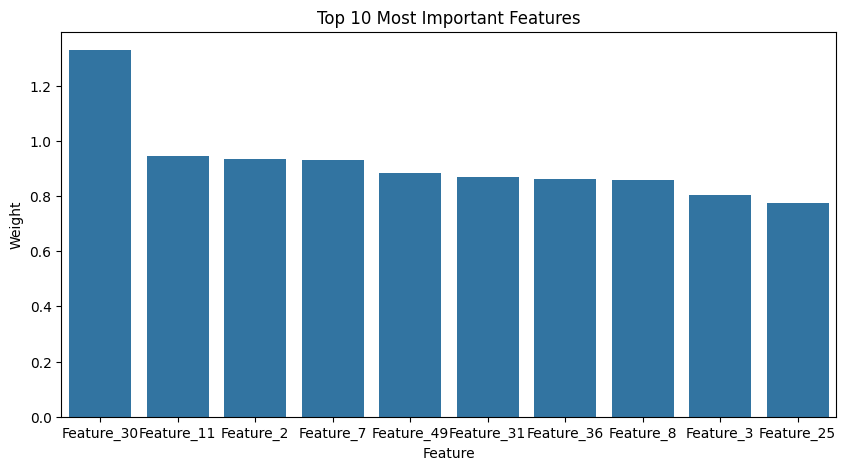

In [7]:
import numpy as np

importance = pd.DataFrame({
    'Feature': df.columns[:-1],
    'Weight': np.abs(Log_reg_model.coef_[0])
}).sort_values('Weight', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=importance.head(10), x='Feature', y='Weight')
plt.title("Top 10 Most Important Features")
plt.show()

## Models Comparision

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [9]:
models = {
   'Logistic Regression': LogisticRegression(max_iter=1000),
   'K-Nearest Neighbors': KNeighborsClassifier(),
   'Support Vector Machine': SVC(),
   'Random Forest': RandomForestClassifier(),
   'Gradient Boosting': GradientBoostingClassifier(),
   'Naive Bayes': GaussianNB(),
   'Neural Network': MLPClassifier(max_iter=1000)
}

results = []

for name, model in models.items():
   pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('classifier', model)
   ])

   scores = cross_val_score(pipeline, x_train, y_train, cv=5)
   
   # fit the model and test on test set
   pipeline.fit(x_train, y_train)
   y_pred = pipeline.predict(x_test)
   test_acc = accuracy_score(y_test, y_pred)

   results.append({
      'model': name,
      'cv_mean_accuracy': scores.mean(),
      'test_accuracy': test_acc
   })


## print results

results_df = pd.DataFrame(results).sort_values(by='cv_mean_accuracy', ascending=False)
print(results_df)

c:\Users\lmokh phone\OneDrive\Bureau\sonarMlProject\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\lmokh phone\OneDrive\Bureau\sonarMlProject\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


                    model  cv_mean_accuracy  test_accuracy
6          Neural Network          0.867558       0.857143
2  Support Vector Machine          0.849376       0.857143
1     K-Nearest Neighbors          0.825668       0.738095
4       Gradient Boosting          0.825312       0.880952
3           Random Forest          0.819073       0.857143
0     Logistic Regression          0.771123       0.833333
5             Naive Bayes          0.650624       0.642857


## Fine_Tune the top model

In [18]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', MLPClassifier(random_state=42))
])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (64, 64, 32)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'lbfgs'],
    'classifier__alpha': [1e-5, 1e-4, 1e-3],
    'classifier__learning_rate_init': [0.001, 0.01],
    'classifier__max_iter': [500, 1000]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(x_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Params: {'classifier__activation': 'relu', 'classifier__alpha': 1e-05, 'classifier__hidden_layer_sizes': (64, 64, 32), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 500, 'classifier__solver': 'adam'}
Best Score: 0.8319264069264068


In [19]:
#get the best model and refit on the whole training data
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.88      0.95      0.91        22
           R       0.94      0.85      0.89        20

    accuracy                           0.90        42
   macro avg       0.91      0.90      0.90        42
weighted avg       0.91      0.90      0.90        42



In [20]:
y_train_pred = best_model.predict(x_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           M       1.00      1.00      1.00        89
           R       1.00      1.00      1.00        77

    accuracy                           1.00       166
   macro avg       1.00      1.00      1.00       166
weighted avg       1.00      1.00      1.00       166



After hyperparameter tuning with 3-fold cross-validation, the best MLPClassifer model achieved a training accuracy of 100% and a test accuracy of 90%.


The small generalization gap suggests mild overfitting, which is expected due to the limited dataset size (208 samples).

Cross-validation confirmed stable performance, indicating the model generalizes reasonably well.